In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
config = backend.configuration()

In [117]:
backend

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:354: UserWarning: The time delta is now returned in units of [s] rather than [ns].
  warnings.warn("The time delta is now returned in units of [s] rather than [ns].")
/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:348: UserWarning: The time delta is now returned in units of [s] rather than [ns].
  warnings.warn("The time delta is now returned in units of [s] rather than [ns].")


<IBMQBackend('alt_almaden') from IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='pulse-testing')>

## Direct RX Gate

In [21]:
# Standard X gate
circuit = q.QuantumCircuit(1)
# standard X gate is U3(pi, 0, pi)
schedule = cmd_def.get('u3', qubits=[0], P0=np.pi, P1=0, P2=np.pi)
#schedule = q.pulse.SamplePulse([-0.1])(system.qubits[0].drive) + schedule  # to set a standard scale
schedule.draw(channels_to_plot=[system.qubits[0].drive])
measure = cmd_def.get('measure', qubits=config.meas_map[0])
schedule |= measure << schedule.duration

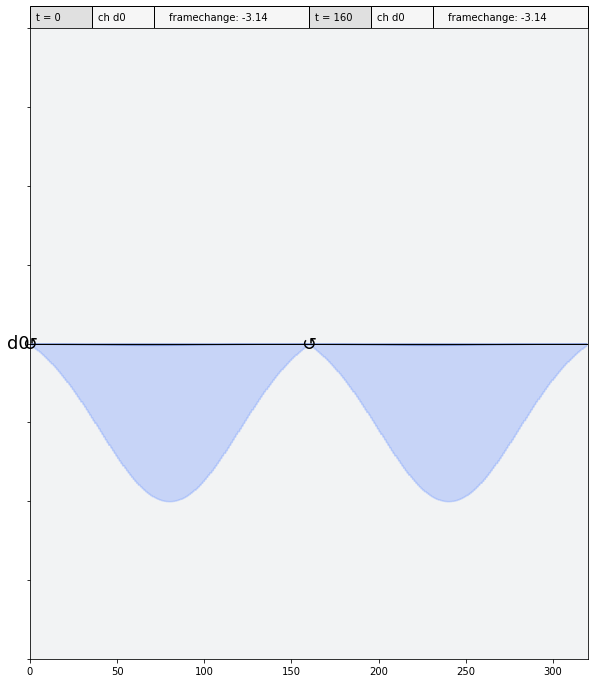

In [23]:
schedule.draw(channels_to_plot=[system.qubits[0].drive])

In [24]:
from qiskit import execute
job = execute(schedule, backend)

In [113]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [111]:
job.queue_position()

In [112]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=0, status_msg='active')

In [74]:
from qiskit.ignis.verification.tomography.data import marginal_counts
marginal_counts(job.result().get_counts(), [0])

{'0': 62, '1': 962}

        ┌───┐
q_0: |0>┤ X ├
        └───┘
        ┌─────────────────────────────────┐
q_0: |0>┤ Direct_rx_3.141592653589793(pi) ├
        └─────────────────────────────────┘
                  ┌─────────────────────────────────┐
        (q0) q0|0>┤ Direct_rx_3.141592653589793(pi) ├
                  └─────────────────────────────────┘
  (ancilla0) q1|0>───────────────────────────────────
                                                     
  (ancilla1) q2|0>───────────────────────────────────
                                                     
  (ancilla2) q3|0>───────────────────────────────────
                                                     
  (ancilla3) q4|0>───────────────────────────────────
                                                     
  (ancilla4) q5|0>───────────────────────────────────
                                                     
  (ancilla5) q6|0>───────────────────────────────────
                                                     
  (ancilla6) q7|

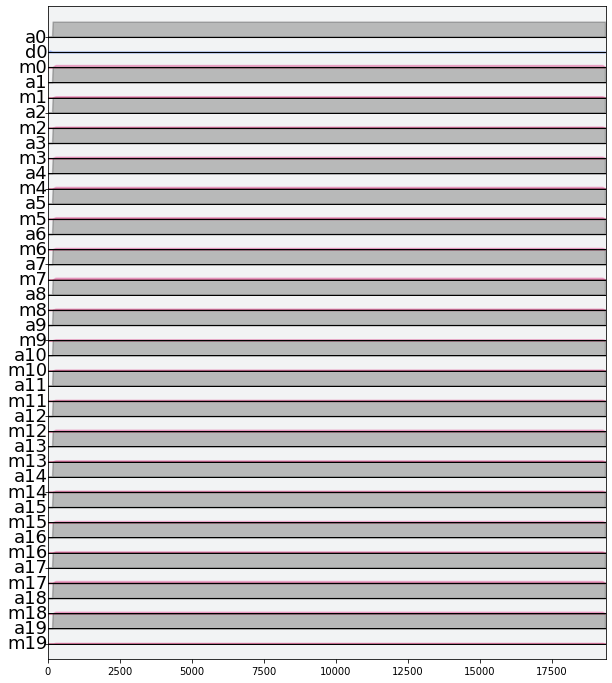

In [78]:
# Our way
circuit = q.QuantumCircuit(1)
circuit.x(0)
print(circuit)

decomposed_circuit = circuit.decompose()
print(decomposed_circuit)

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
print(transpiled_circuit)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
#schedule = q.pulse.SamplePulse([0.1])(system.qubits[0].drive) + schedule  # to set a standard scale
measure = cmd_def.get('measure', qubits=config.meas_map[0])
schedule |= measure << schedule.duration
schedule.draw()

In [79]:
job = execute(schedule, backend)

In [114]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [115]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=0, status_msg='active')

In [116]:
marginal_counts(job.result().get_counts(), [0])

{'0': 71, '1': 953}

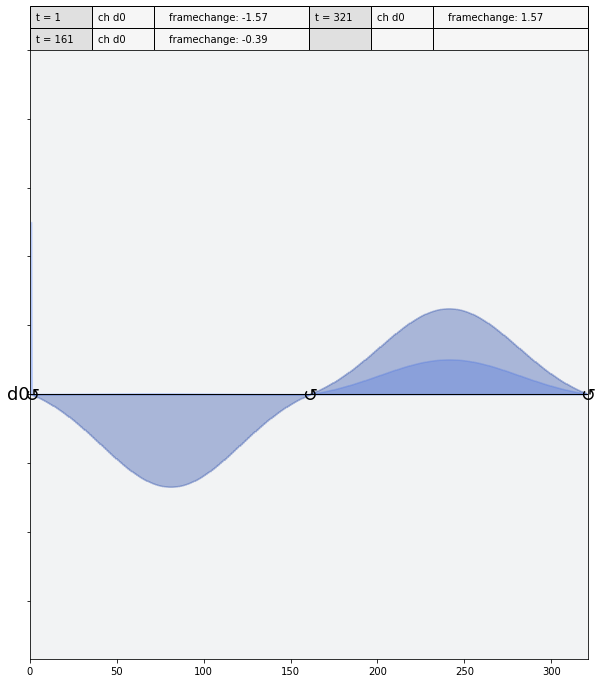

In [8]:
# rx(pi/8) gate
circuit = q.QuantumCircuit(1)
# standard rx(pi/8) gate decomposition is U3(pi/8, -pi/2, pi/2)
schedule = cmd_def.get('u3', qubits=[0], P0=np.pi/8, P1=-np.pi/2, P2=np.pi/2)
schedule = q.pulse.SamplePulse([0.1])(system.qubits[0].drive) + schedule  # to set a standard scale
schedule.draw(channels_to_plot=[system.qubits[0].drive])

        ┌──────────┐
q_0: |0>┤ Rx(pi/8) ├
        └──────────┘
        ┌─────────────────────────────────────┐
q_0: |0>┤ Direct_rx_0.39269908169872414(pi/8) ├
        └─────────────────────────────────────┘
                  ┌─────────────────────────────────────┐
        (q0) q0|0>┤ Direct_rx_0.39269908169872414(pi/8) ├
                  └─────────────────────────────────────┘
  (ancilla0) q1|0>───────────────────────────────────────
                                                         
  (ancilla1) q2|0>───────────────────────────────────────
                                                         
  (ancilla2) q3|0>───────────────────────────────────────
                                                         
  (ancilla3) q4|0>───────────────────────────────────────
                                                         
  (ancilla4) q5|0>───────────────────────────────────────
                                                         
  (ancilla5) q6|0>─────────────────────

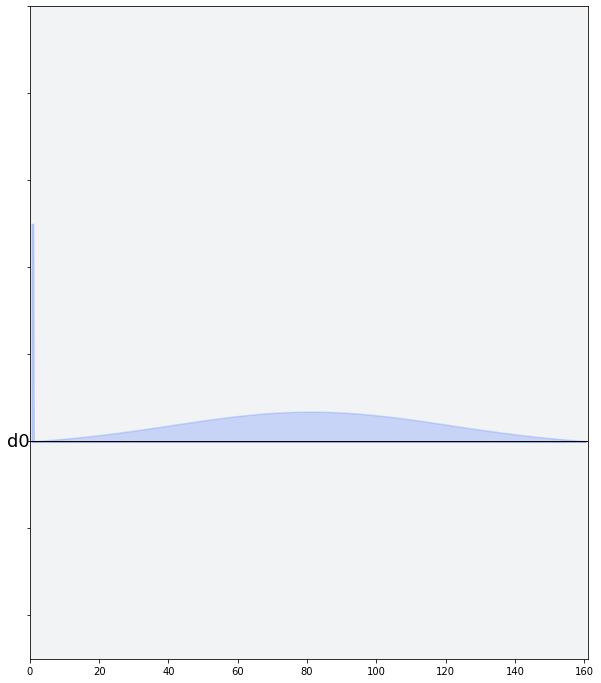

In [9]:
# Our way
circuit = q.QuantumCircuit(1)
circuit.rx(np.pi/8, 0)
print(circuit)

decomposed_circuit = circuit.decompose()
print(decomposed_circuit)

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
print(transpiled_circuit)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule = q.pulse.SamplePulse([0.1])(system.qubits[0].drive) + schedule  # to set a standard scale
schedule.draw(channels_to_plot=[system.qubits[0].drive])